# 日経平均株価 週足 メディアン統計

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = "N225"
symbol = "^%s" % code
ticker = yf.Ticker(symbol)

In [4]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period="10y", interval="1wk")

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_3y = datetime.timedelta(days=365 * 3)
df = df0[df0.index >= dt_last - tdelta_3y]

In [5]:
dt = df.tail(1).index[0]
date_str = f"{dt.month:02d}{dt.day:02d}"
date_str

'1222'

## Moving Median

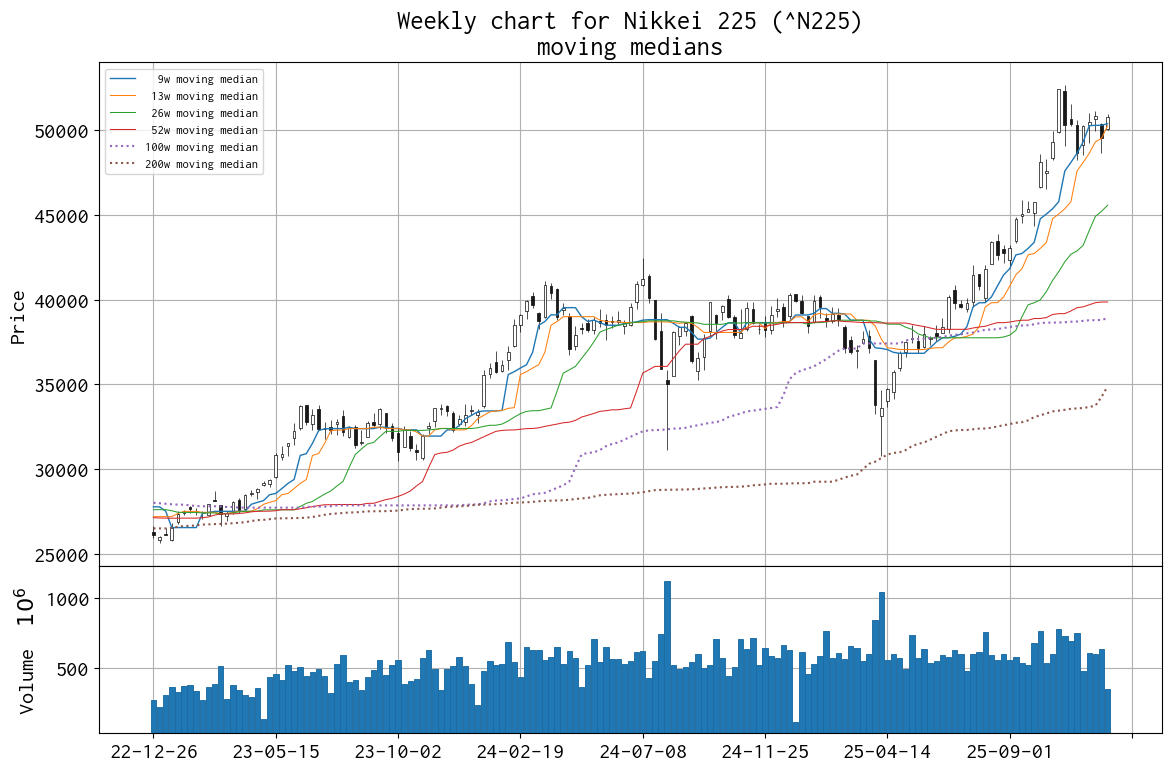

In [6]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

mm09 = df0["Close"].rolling(9).median()
mm13 = df0["Close"].rolling(13).median()
mm26 = df0["Close"].rolling(26).median()
mm52 = df0["Close"].rolling(52).median()
mm100 = df0["Close"].rolling(100).median()
mm200 = df0["Close"].rolling(200).median()

apds = [
    mpf.make_addplot(mm09[df.index], width=1, label="  9w moving median", ax=ax[0]),
    mpf.make_addplot(mm13[df.index], width=0.75, label=" 13w moving median", ax=ax[0]),
    mpf.make_addplot(mm26[df.index], width=0.75, label=" 26w moving median", ax=ax[0]),
    mpf.make_addplot(mm52[df.index], width=0.75, label=" 52w moving median", ax=ax[0]),
    mpf.make_addplot(
        mm100[df.index],
        width=1.5,
        linestyle="dotted",
        label="100w moving median",
        ax=ax[0],
    ),
    mpf.make_addplot(
        mm200[df.index],
        width=1.5,
        linestyle="dotted",
        label="200w moving median",
        ax=ax[0],
    ),
]

mpf.plot(
    df,
    type="candle",
    style="default",
    volume=ax[1],
    datetime_format="%y-%m-%d",
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

ax[0].set_title(
    f"Weekly chart for {ticker.info["longName"]} ({symbol})\nmoving medians"
)
ax[0].legend(loc="upper left", fontsize=9)

plt.tight_layout()
plt.savefig(f"{date_str}_report_weekly_chart_median_{code}.png")
plt.show()

In [7]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-12-15 00:00:00+09:00,50352.089844,50432.101562,48643.781250,49507.210938,639200000,0.0,0.0
2025-12-22 00:00:00+09:00,50084.550781,50941.890625,49982.199219,50750.390625,347100000,0.0,0.0


In [8]:
df.tail(2)["Close"]

Date
2025-12-15 00:00:00+09:00    49507.210938
2025-12-22 00:00:00+09:00    50750.390625
Name: Close, dtype: float64

In [9]:
df.tail(2)["Close"].diff()

Date
2025-12-15 00:00:00+09:00            NaN
2025-12-22 00:00:00+09:00    1243.179688
Name: Close, dtype: float64

In [10]:
df["Close"].rolling(9).median().tail(5)

Date
2025-11-24 00:00:00+09:00    49299.648438
2025-12-01 00:00:00+09:00    50253.910156
2025-12-08 00:00:00+09:00    50276.371094
2025-12-15 00:00:00+09:00    50276.371094
2025-12-22 00:00:00+09:00    50376.531250
Name: Close, dtype: float64

In [11]:
df["Close"].rolling(13).median().tail(5)

Date
2025-11-24 00:00:00+09:00    48088.800781
2025-12-01 00:00:00+09:00    48625.878906
2025-12-08 00:00:00+09:00    49299.648438
2025-12-15 00:00:00+09:00    49507.210938
2025-12-22 00:00:00+09:00    50253.910156
Name: Close, dtype: float64

In [12]:
df["Close"].rolling(26).median().tail(5)

Date
2025-11-24 00:00:00+09:00    43198.529297
2025-12-01 00:00:00+09:00    44073.214844
2025-12-08 00:00:00+09:00    44906.964844
2025-12-15 00:00:00+09:00    45200.398438
2025-12-22 00:00:00+09:00    45562.244141
Name: Close, dtype: float64

In [13]:
df["Close"].rolling(52).median().tail(5)

Date
2025-11-24 00:00:00+09:00    39571.083984
2025-12-01 00:00:00+09:00    39691.683594
2025-12-08 00:00:00+09:00    39814.994141
2025-12-15 00:00:00+09:00    39856.824219
2025-12-22 00:00:00+09:00    39856.824219
Name: Close, dtype: float64

In [14]:
df0["Close"].rolling(100).median().tail(5)

Date
2025-11-24 00:00:00+09:00    38742.291016
2025-12-01 00:00:00+09:00    38781.980469
2025-12-08 00:00:00+09:00    38787.199219
2025-12-15 00:00:00+09:00    38800.968750
2025-12-22 00:00:00+09:00    38898.154297
Name: Close, dtype: float64

In [15]:
df0["Close"].rolling(200).median().tail(5)

Date
2025-11-24 00:00:00+09:00    33605.554688
2025-12-01 00:00:00+09:00    33665.804688
2025-12-08 00:00:00+09:00    33743.328125
2025-12-15 00:00:00+09:00    34255.429688
2025-12-22 00:00:00+09:00    34877.640625
Name: Close, dtype: float64

## Robust Bollinger bands

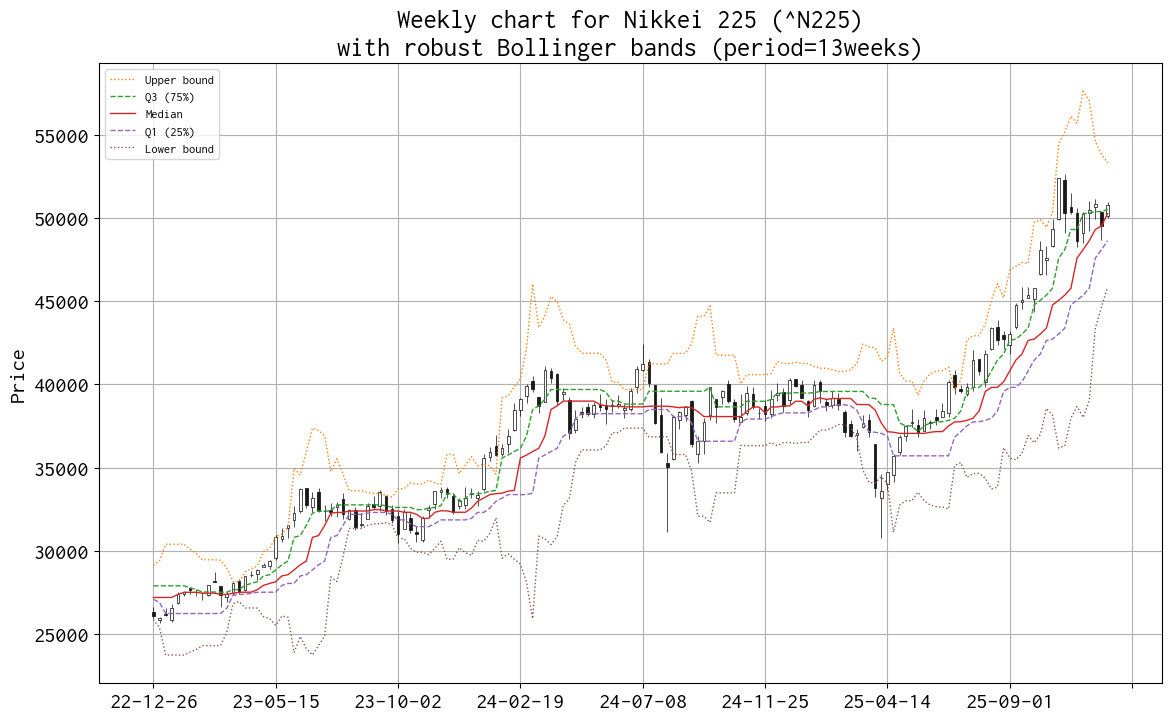

In [16]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(figsize=(12, 7.5))

# Bollinger bands
period = 13
mv_median = df0["Close"].rolling(period).median()
mv_q1 = df0["Close"].rolling(period).quantile(0.25)
mv_q3 = df0["Close"].rolling(period).quantile(0.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds = [
    mpf.make_addplot(
        mv_upper[df.index],
        width=1,
        color="C1",
        linestyle="dotted",
        label="Upper bound",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_q3[df.index],
        width=1,
        color="C2",
        linestyle="dashed",
        label="Q3 (75%)",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_median[df.index],
        width=1,
        color="C3",
        linestyle="solid",
        label="Median",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_q1[df.index],
        width=1,
        color="C4",
        linestyle="dashed",
        label="Q1 (25%)",
        ax=ax,
    ),
    mpf.make_addplot(
        mv_lower[df.index],
        width=1,
        color="C5",
        linestyle="dotted",
        label="Lower bound",
        ax=ax,
    ),
]

mpf.plot(
    df,
    type="candle",
    style="default",
    addplot=apds,
    datetime_format="%y-%m-%d",
    xrotation=0,
    ax=ax,
)
#    fill_between=dict(y1=mv_q1[df.index].values,y2=mv_q3[df.index].values, color='blue'),
# ax.fill_between(df.index, y1=mv_q1[df.index].values, y2=mv_q3[df.index].values, color='blue')

ax.grid()
ax.legend(loc="best", fontsize=9)

try:
    ax.set_title(
        f"Weekly chart for {ticker.info['longName']} ({symbol})\nwith robust Bollinger bands (period={period}weeks)"
    )
except KeyError:
    ax.set_title(
        f"Weekly chart for {symbol}\nwith robust Bollinger bands (period={period}weeks)"
    )

plt.tight_layout()
plt.savefig(f"{date_str}_report_weekly_chart_bollinger_robust_{code}.png")
plt.show()

## ヒストグラムと Q-Q プロット

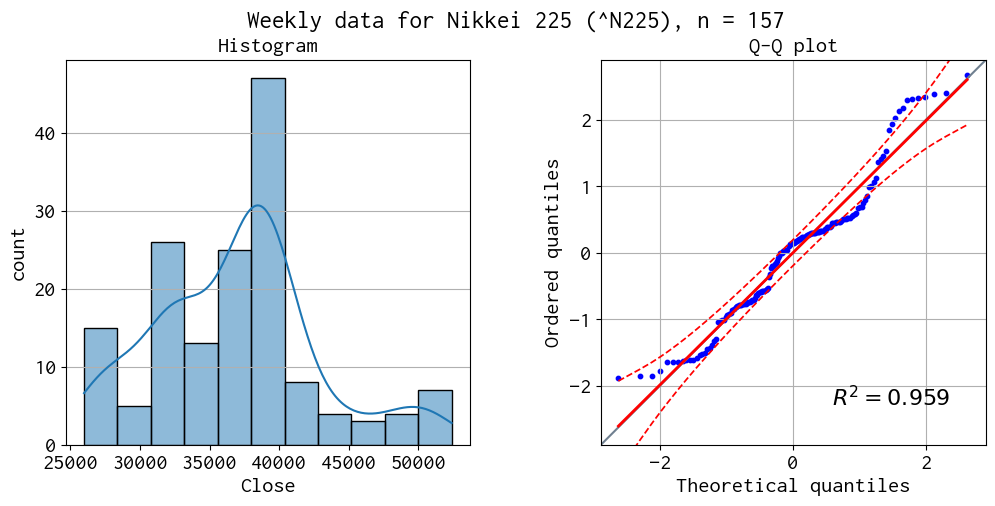

In [17]:
plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df["Close"], kde=True, ax=axes[0])

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis="y")
axes[0].set_title("Histogram", fontsize=16)

# Q-Q プロット
pg.qqplot(df["Close"], s=10, ax=axes[1])
axes[1].set_title("Q-Q plot", fontsize=16)
axes[1].grid()

plt.suptitle(
    "Weekly data for %s (%s), n = %d" % (ticker.info["longName"], symbol, len(df)),
    fontsize=18,
)
plt.subplots_adjust(wspace=0.3)
plt.savefig(f"{date_str}_report_weekly_histogram_qqplot_{code}.png")
plt.show()